# Dress_Size_Prediction

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [260]:
df=pd.read_csv(r'file:///C:/Users/Admin/Documents/01_Learnbay/02_MyProjects/final_test.csv')
df.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [262]:
df.describe(percentiles=(0.01,0.10,0.25,0.50,0.75,0.80,0.90,0.95,0.99)).T

,count,mean,std,min,1%,10%,25%,50%,75%,80%,90%,95%,99%,max
weight,119734.0,61.756811,9.944863,22.00,45.0,52.00,55.00,61.0,67.00,68.00,74.00,80.0,95.00,136.00
age,119477.0,34.027311,8.149447,0.00,20.0,26.00,29.00,32.0,37.00,39.00,45.00,50.0,59.00,117.00
height,119404.0,165.805794,6.737651,137.16,152.4,157.48,160.02,165.1,170.18,172.72,175.26,177.8,180.34,193.04


From description,
- weight and age varaibles are right skewed distribution as there is huge difference between 99% quartile and max value and 1% quartile and min value.

## Exploratory Data Analysis

### Histogram plots

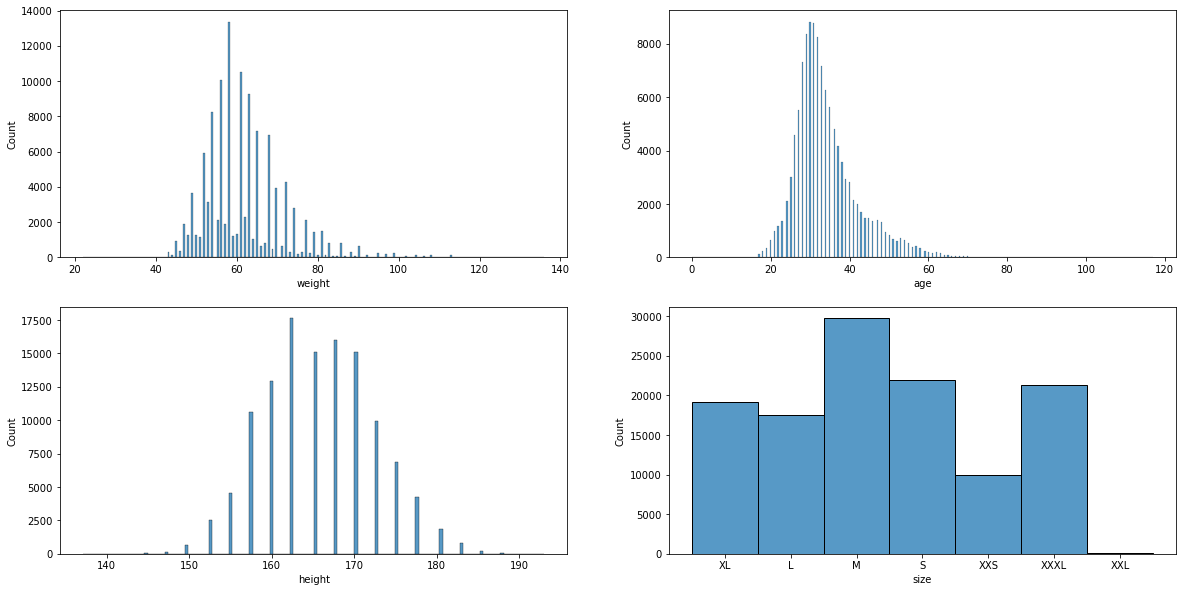

In [264]:
plt.figure(figsize=(20,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(2,2,i)
    sns.histplot(data=df,x=col)

Histograms indicates,
- weight and age variables are right skewed distributions.
- height variable id more likely normally distributed.
- Number of counts for XXL is very low.

### Box plots

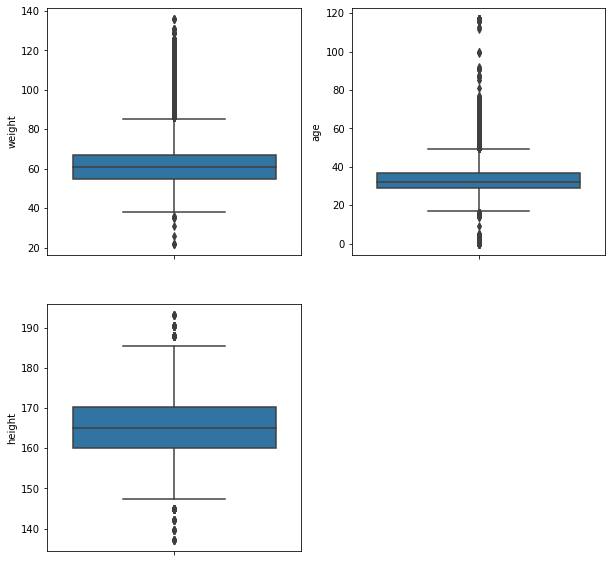

In [265]:
plt.figure(figsize=(10,10))
for i,col in enumerate(df.drop(['size'],axis=1).columns,1):
    plt.subplot(2,2,i)
    ax=sns.boxplot(data=df,y=col)

### Correlation Heatmap

<AxesSubplot:>

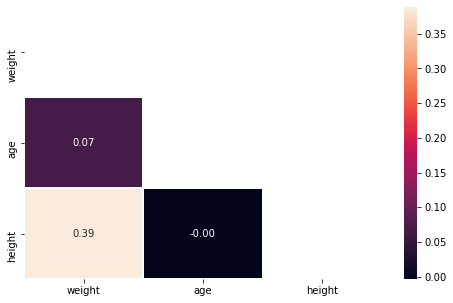

In [316]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,fmt='0.2F',mask=np.triu(df.corr()))

### Outlier treatment

In [274]:
def outlier_cap(x):
    x=x.clip(lower=x.quantile(0.01))
    x=x.clip(upper=x.quantile(0.99))
    return(x)

In [275]:
X=df.drop(['size'],axis=1)
y=df['size']

In [276]:
X=X.apply(lambda x:outlier_cap(x))
X.head()

,weight,age,height
0,62,28.0,172.72
1,59,36.0,167.64
2,61,34.0,165.10
3,65,27.0,175.26
4,62,45.0,172.72


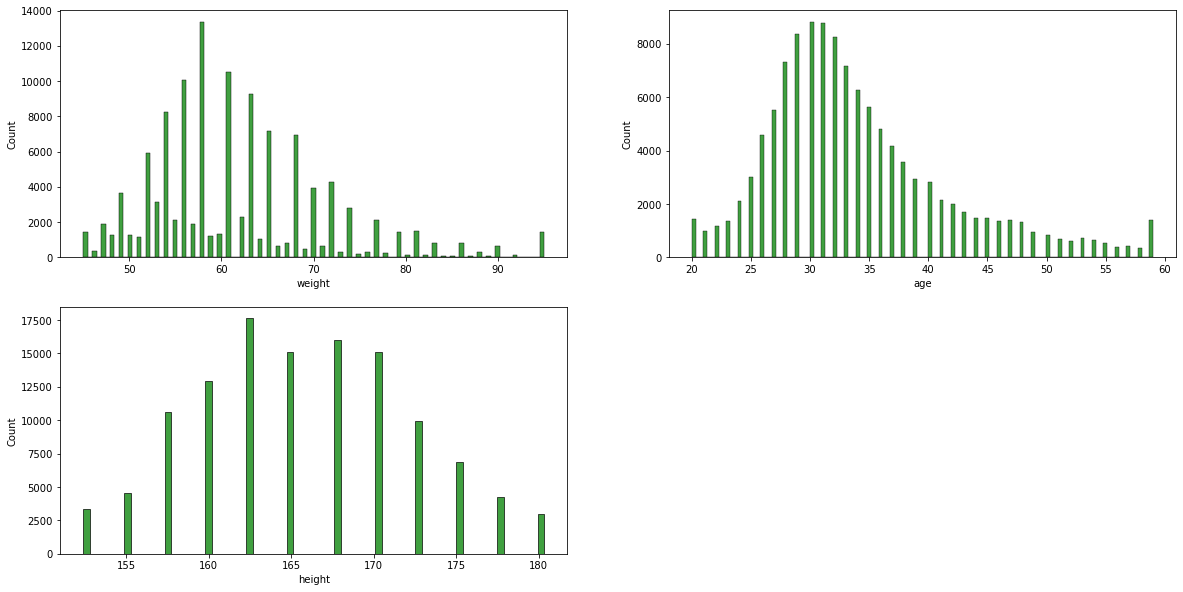

In [288]:
plt.figure(figsize=(20,10))
for i,col in enumerate(X.columns,1):
    plt.subplot(2,2,i)
    sns.histplot(data=X,x=col,color='g')

In [281]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,119734.0,61.669826,9.509611,45.0,55.00,61.0,67.00,95.00
age,119477.0,33.981486,7.815205,20.0,29.00,32.0,37.00,59.00
height,119404.0,165.795860,6.588928,152.4,160.02,165.1,170.18,180.34


In [284]:
X.isnull().sum()

weight      0
age       257
height    330
dtype: int64

### Scaling

In [285]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_sc=scaler.fit_transform(X)
X_sc

array([[ 0.03472013, -0.7653684 ,  1.05087941],
       [-0.28075151,  0.25828145,  0.27988583],
       [-0.07043708,  0.00236898, -0.10561096],
       ...,
       [-0.07043708, -0.38149971,  1.05087941],
       [ 1.29660669, -0.38149971,  0.27988583],
       [ 0.87597784, -0.50945594,  0.27988583]])

### Missing value imputation using KNNImputer

In [289]:
from sklearn.impute import KNNImputer
impute=KNNImputer(n_neighbors=5)
X_sc_i=impute.fit_transform(X_sc)
X_sc_i=pd.DataFrame(X_sc_i,columns=['weight','age','height'])
X_sc_i.head()

,weight,age,height
0,0.034720,-0.765368,1.050879
1,-0.280752,0.258281,0.279886
2,-0.070437,0.002369,-0.105611
3,0.350192,-0.893325,1.436376
4,0.034720,1.409888,1.050879


<AxesSubplot:>

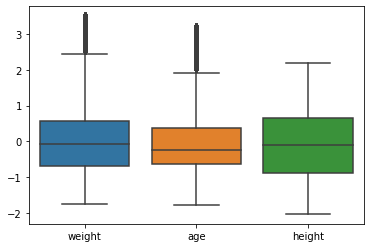

In [290]:
sns.boxplot(data=X_sc_i)

### LabelEncoding

In [291]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
print(y.value_counts())
y=label.fit_transform(y)
pd.DataFrame(y).value_counts()

M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: size, dtype: int64


1    29712
2    21924
6    21359
3    19119
0    17587
5     9964
4       69
dtype: int64

### Data splitting 

In [292]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_sc_i,y,test_size=0.2,random_state=13)

## DecisionTreeClassifier

In [293]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,f1_score,accuracy_score
params={'criterion':['gini','entropy'],
       'splitter':['best','random'],
       'max_depth':range(1,5),
       'min_samples_split':range(1,5),
       'min_samples_leaf':range(1,5),
       'max_features':['auto','sqrt','log2']}
grid_DT=GridSearchCV(DecisionTreeClassifier(),params,scoring=make_scorer(accuracy_score),cv=5,verbose=1,n_jobs=-1)
grid_DT.fit(X_train,y_train)
print(grid_DT.best_score_)
print(grid_DT.best_params_)
DT_clf=grid_DT.best_estimator_

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2388 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.1min finished


0.44844266913129827
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}


### print_score function 

In [353]:
result_df={'models':[],'Train_score':[],'Test_score':[]}

In [354]:
from sklearn.metrics import confusion_matrix,classification_report
def print_score(clf,X_train,y_train,X_test,y_test):
    y_pred=clf.predict(X_train)
    print('Train data evaluation\n=====================================================================================================')
    print('Train accuracy score: ',accuracy_score(y_train,y_pred))
    print('\nConfusion Matrix:')
    display(pd.DataFrame(confusion_matrix(y_train,y_pred)))
    print('\nClassification Report:')
    clf_report=classification_report(y_train,y_pred,output_dict=True)
    display(pd.DataFrame(clf_report))

    print('\nTest data evaluation\n=======================================================================================================')
    y_pred1=clf.predict(X_test)
    print('Test accuracy score: ',accuracy_score(y_test,y_pred1))
    print('\nConfusion Matrix:')
    display(pd.DataFrame(confusion_matrix(y_test,y_pred1)))
    print('\nClassification Report:')
    clf_report=classification_report(y_test,y_pred1,output_dict=True)
    display(pd.DataFrame(clf_report))
    
    result_df['models'].append(clf)
    result_df['Train_score'].append(accuracy_score(y_train,y_pred))
    result_df['Test_score'].append(accuracy_score(y_test,y_pred1))

### Results

In [355]:
print_score(DT_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.46476035370144175

Confusion Matrix:


,0,1,2,3,4,5,6
0,0,9403,1431,2196,0,0,1136
1,0,13599,8898,829,0,0,375
2,0,3701,13709,85,0,0,67
3,0,6662,633,3858,0,0,4083
4,0,19,1,7,0,0,33
5,0,333,7606,8,0,0,14
6,0,1407,115,2227,0,0,13352



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.0,0.387171,0.423209,0.418893,0.0,0.0,0.700525,0.46476,0.275685,0.365088
recall,0.0,0.573773,0.780606,0.253216,0.0,0.0,0.780773,0.46476,0.341195,0.464760
f1-score,0.0,0.462354,0.548854,0.315634,0.0,0.0,0.738475,0.46476,0.295045,0.397078
support,14166.0,23701.000000,17562.000000,15236.000000,60.0,7961.0,17101.000000,0.46476,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.4654445233223368

Confusion Matrix:


,0,1,2,3,4,5,6
0,0,2266,358,488,0,0,309
1,0,3452,2214,241,0,0,104
2,0,937,3387,23,0,0,15
3,0,1664,164,1002,0,0,1053
4,0,5,0,0,0,0,4
5,0,62,1938,2,0,0,1
6,0,390,27,536,0,0,3305



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.0,0.393345,0.418769,0.437173,0.0,0.0,0.689835,0.465445,0.277017,0.368561
recall,0.0,0.574280,0.776479,0.258048,0.0,0.0,0.776186,0.465445,0.340713,0.465445
f1-score,0.0,0.466897,0.544096,0.324534,0.0,0.0,0.730467,0.465445,0.295142,0.398812
support,3421.0,6011.000000,4362.000000,3883.000000,9.0,2003.0,4258.000000,0.465445,23947.000000,23947.000000


## RandomForestClassifier

In [296]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,f1_score,accuracy_score
params={'n_estimators':range(1,5),
       'criterion':['gini','entropy'],
       'max_depth':range(1,5),
       'min_samples_split':range(1,5),
       'min_samples_leaf':range(1,10),
       'max_features':['log2','sqrt']}
grid_RF=GridSearchCV(RandomForestClassifier(),params,scoring=make_scorer(accuracy_score),cv=5,verbose=1,n_jobs=-1)
grid_RF.fit(X_train,y_train)
print(grid_RF.best_score_)
print(grid_RF.best_params_)
RF_clf=grid_RF.best_estimator_

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

0.47679734312058136
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 4}


### Results

In [356]:
print_score(RF_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.45673212440101474

Confusion Matrix:


,0,1,2,3,4,5,6
0,0,7672,348,3991,0,0,2155
1,0,17717,2963,2361,0,0,660
2,0,10493,6719,263,0,0,87
3,0,4382,167,4561,0,0,6126
4,0,10,1,16,0,0,33
5,0,2765,5158,19,0,0,19
6,0,747,51,1551,0,0,14752



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.0,0.404627,0.436100,0.357389,0.0,0.0,0.619000,0.456732,0.259588,0.347433
recall,0.0,0.747521,0.382587,0.299357,0.0,0.0,0.862640,0.456732,0.327444,0.456732
f1-score,0.0,0.525049,0.407595,0.325809,0.0,0.0,0.720788,0.456732,0.282749,0.385152
support,14166.0,23701.000000,17562.000000,15236.000000,60.0,7961.0,17101.000000,0.456732,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.4573850586712323

Confusion Matrix:


,0,1,2,3,4,5,6
0,0,1883,67,961,0,0,510
1,0,4464,763,609,0,0,175
2,0,2629,1640,68,0,0,25
3,0,1077,32,1211,0,0,1563
4,0,1,0,5,0,0,3
5,0,696,1302,4,0,0,1
6,0,193,3,424,0,0,3638



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.0,0.407932,0.430785,0.368982,0.0,0.0,0.615046,0.457385,0.260392,0.350056
recall,0.0,0.742638,0.375974,0.311872,0.0,0.0,0.854392,0.457385,0.326411,0.457385
f1-score,0.0,0.526601,0.401518,0.338032,0.0,0.0,0.715227,0.457385,0.283054,0.387307
support,3421.0,6011.000000,4362.000000,3883.000000,9.0,2003.0,4258.000000,0.457385,23947.000000,23947.000000


## Support Vector Machine

In [298]:
SVC_clf=SVC(C=1,gamma=0.01,kernel='rbf')
SVC_clf.fit(X_train,y_train)

SVC(C=1, gamma=0.01)

### Results

In [357]:
print_score(SVC_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.5139423930178416

Confusion Matrix:


,0,1,2,3,4,5,6
0,1954,7340,442,3774,0,23,633
1,1282,16155,4311,1490,0,267,196
2,139,6528,9088,139,0,1621,47
3,1705,3843,223,6423,0,17,3025
4,4,6,1,20,0,0,29
5,11,778,4463,15,0,2680,14
6,297,605,46,3208,0,16,12929



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.362389,0.458233,0.489286,0.426239,0.0,0.579585,0.766254,0.513942,0.440284,0.509453
recall,0.137936,0.681617,0.517481,0.421567,0.0,0.336641,0.756038,0.513942,0.407326,0.513942
f1-score,0.199816,0.548036,0.502989,0.423890,0.0,0.425904,0.761111,0.513942,0.408821,0.496078
support,14166.000000,23701.000000,17562.000000,15236.000000,60.0,7961.000000,17101.000000,0.513942,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.5143024178393953

Confusion Matrix:


,0,1,2,3,4,5,6
0,474,1789,97,900,0,7,154
1,304,4061,1112,404,0,74,56
2,29,1674,2225,33,0,388,13
3,383,1009,54,1659,0,4,774
4,1,1,0,4,0,0,3
5,0,172,1138,2,0,690,1
6,76,148,5,818,0,4,3207



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.374112,0.458663,0.480458,0.434293,0.0,0.591260,0.762120,0.514302,0.442986,0.511478
recall,0.138556,0.675595,0.510087,0.427247,0.0,0.344483,0.753171,0.514302,0.407020,0.514302
f1-score,0.202218,0.546384,0.494829,0.430741,0.0,0.435331,0.757619,0.514302,0.409589,0.497141
support,3421.000000,6011.000000,4362.000000,3883.000000,9.0,2003.000000,4258.000000,0.514302,23947.000000,23947.000000


## AdaBoostClassifier

In [300]:
from sklearn.ensemble import AdaBoostClassifier
params={'n_estimators':[50,100,150,200],
        'learning_rate':[0.1,0.25,0.5,0.7,1]}
grid_Ada=GridSearchCV(AdaBoostClassifier(),params,scoring=make_scorer(accuracy_score),cv=5,verbose=1,n_jobs=-1)
grid_Ada.fit(X_train,y_train)
print(grid_Ada.best_score_)
print(grid_Ada.best_params_)
Ada_clf=grid_Ada.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


0.48813506961173675
{'learning_rate': 0.25, 'n_estimators': 150}


### Results

In [361]:
print_score(Ada_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.49195611095451364

Confusion Matrix:


,0,1,2,3,4,5,6
0,2659,6311,348,4016,3,36,793
1,2169,15949,3364,1720,1,273,225
2,291,7699,8766,155,3,598,50
3,2115,3226,171,6257,11,18,3438
4,4,6,1,18,1,0,30
5,22,1055,6509,16,0,345,14
6,403,523,49,2941,28,11,13146



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.346992,0.458713,0.456372,0.413741,0.021277,0.269321,0.742880,0.491956,0.387042,0.469326
recall,0.187703,0.672925,0.499146,0.410672,0.016667,0.043336,0.768727,0.491956,0.371311,0.491956
f1-score,0.243621,0.545545,0.476802,0.412201,0.018692,0.074659,0.755582,0.491956,0.361014,0.465112
support,14166.000000,23701.000000,17562.000000,15236.000000,60.000000,7961.000000,17101.000000,0.491956,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.49070864826491833

Confusion Matrix:


,0,1,2,3,4,5,6
0,623,1544,72,975,1,10,196
1,553,4048,838,436,3,71,62
2,85,1925,2155,37,0,147,13
3,548,827,35,1600,1,2,870
4,1,1,0,5,0,0,2
5,2,261,1663,2,0,74,1
6,109,132,7,749,10,0,3251



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.324310,0.463264,0.451782,0.420610,0.0,0.243421,0.739704,0.490709,0.377584,0.464997
recall,0.182110,0.673432,0.494039,0.412053,0.0,0.036945,0.763504,0.490709,0.366012,0.490709
f1-score,0.233246,0.548919,0.471967,0.416287,0.0,0.064153,0.751416,0.490709,0.355141,0.463552
support,3421.000000,6011.000000,4362.000000,3883.000000,9.0,2003.000000,4258.000000,0.490709,23947.000000,23947.000000


## GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
params={'n_estimators':[50,100,150,200],
        'learning_rate':[0.1,0.25,0.5,0.7],
       'subsample':[0.1,0.25,0.5,0.7],
       'max_depth':range(1,5)}
grid_GB=GridSearchCV(GradientBoostingClassifier(),params,scoring=make_scorer(accuracy_score),cv=5,verbose=1,n_jobs=-1)
grid_GB.fit(X_train,y_train)
print(grid_GB.best_score_)
print(grid_GB.best_params_)
GB_clf=grid_GB.best_estimator_

In [305]:
GB_clf=GradientBoostingClassifier(n_estimators=20,learning_rate=0.1,max_depth=5,subsample=0.7)
GB_clf.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=20, subsample=0.7)

### Results

In [362]:
print_score(GB_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.5192249470178626

Confusion Matrix:


,0,1,2,3,4,5,6
0,1363,7057,479,4472,16,32,747
1,925,15686,4544,1953,1,374,218
2,126,6015,9092,182,0,2099,48
3,1057,3682,238,6906,24,20,3309
4,2,7,1,19,3,0,28
5,9,691,3872,19,1,3355,14
6,191,592,46,2903,19,20,13330



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.371086,0.465046,0.497592,0.419716,0.046875,0.568644,0.753363,0.519225,0.446046,0.509729
recall,0.096216,0.661829,0.517709,0.453269,0.050000,0.421429,0.779487,0.519225,0.425705,0.519225
f1-score,0.152811,0.546256,0.507451,0.435847,0.048387,0.484092,0.766202,0.519225,0.420149,0.497182
support,14166.000000,23701.000000,17562.000000,15236.000000,60.000000,7961.000000,17101.000000,0.519225,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.5155551843654738

Confusion Matrix:


,0,1,2,3,4,5,6
0,313,1729,99,1081,3,14,182
1,215,3955,1150,526,1,106,58
2,24,1526,2233,46,0,521,12
3,280,973,49,1717,5,5,854
4,1,1,0,4,0,0,3
5,0,160,980,2,0,860,1
6,42,151,7,776,10,4,3268



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.357714,0.465568,0.494245,0.413536,0.0,0.569536,0.746460,0.515555,0.435294,0.505413
recall,0.091494,0.657960,0.511921,0.442184,0.0,0.429356,0.767496,0.515555,0.414345,0.515555
f1-score,0.145717,0.545292,0.502928,0.427380,0.0,0.489610,0.756832,0.515555,0.409680,0.494125
support,3421.000000,6011.000000,4362.000000,3883.000000,9.0,2003.000000,4258.000000,0.515555,23947.000000,23947.000000


## XGBClassifier

In [ ]:
from xgboost import XGBClassifier
params={'n_estimators':[50,100,150,200],
        'learning_rate':[0.1,0.25,0.5,0.7],
       'subsample':[0.1,0.25,0.5,0.7],
       'max_depth':range(1,5),
       'colsample_bytree':[0.5,0.7]}
grid_XGB=GridSearchCV(XGBClassifier(),params,scoring=make_scorer(accuracy_score),cv=5,verbose=1,n_jobs=-1)
grid_XGB.fit(X_train,y_train)
print(grid_XGB.best_score_)
print(grid_XGB.best_params_)
XGB_clf=grid_XGB.best_estimator_

In [319]:
XGB_clf=XGBClassifier(n_estimators=200,learning_rate=0.1,max_depth=5,subsample=0.7,colsample_bytree=0.7)
XGB_clf.fit(X_train,y_train)

[21:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Results

In [363]:
print_score(XGB_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.5280570432313362

Confusion Matrix:


,0,1,2,3,4,5,6
0,3132,6012,490,3770,0,33,729
1,2120,14759,4646,1553,0,403,220
2,239,5675,9309,147,0,2141,51
3,2263,2996,237,6586,0,21,3133
4,6,5,1,19,0,0,29
5,22,658,3760,16,0,3492,13
6,415,398,41,2925,0,19,13303



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.382091,0.483854,0.503625,0.438599,0.0,0.571616,0.761128,0.528057,0.448702,0.521724
recall,0.221093,0.622716,0.530065,0.432266,0.0,0.438638,0.777908,0.528057,0.431812,0.528057
f1-score,0.280106,0.544572,0.516507,0.435409,0.0,0.496375,0.769427,0.528057,0.434628,0.518748
support,14166.000000,23701.000000,17562.000000,15236.000000,60.0,7961.000000,17101.000000,0.528057,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.5179354407650227

Confusion Matrix:


,0,1,2,3,4,5,6
0,725,1482,110,919,0,14,171
1,555,3662,1201,426,0,104,63
2,63,1469,2249,35,0,532,14
3,582,791,55,1641,0,4,810
4,0,1,0,5,0,0,3
5,1,146,972,2,0,881,1
6,111,100,6,792,0,4,3245



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.355916,0.478630,0.489658,0.429581,0.0,0.572450,0.753425,0.517935,0.439951,0.511684
recall,0.211926,0.609216,0.515589,0.422611,0.0,0.439840,0.762095,0.517935,0.423040,0.517935
f1-score,0.265665,0.536085,0.502289,0.426068,0.0,0.497459,0.757735,0.517935,0.426472,0.509438
support,3421.000000,6011.000000,4362.000000,3883.000000,9.0,2003.000000,4258.000000,0.517935,23947.000000,23947.000000


## KNNeighborsClassifier

In [330]:
from sklearn.neighbors import KNeighborsClassifier
score_lst=[]
for i in range(2,21):
    knn_clf=KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(X_train,y_train)
    score=knn_clf.score(X_train,y_train)
    score_lst.append(score)

[0.47916731915604416, 0.5070938645118858, 0.5173040182905823, 0.5288191508242246, 0.5282345203420088, 0.535511081879587, 0.5375572885673421, 0.5386221512313779, 0.5417019010930502, 0.5407309968993704, 0.542453568855899, 0.5420777349744746, 0.5427458840970069, 0.5416183824527336, 0.5435497510100535, 0.5433618340693414, 0.543059078998194, 0.5428294027373234, 0.5423178510653847]


<AxesSubplot:>

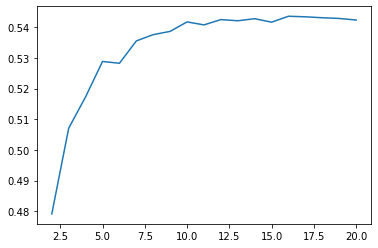

In [346]:
print(score_lst)
sns.lineplot(x=range(2,21),y=score_lst,markers='*')

In [350]:
knn_clf=KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

### Results

In [364]:
print_score(knn_clf,X_train,y_train,X_test,y_test)

Train data evaluation
Train accuracy score:  0.5417019010930502

Confusion Matrix:


,0,1,2,3,4,5,6
0,5502,4482,560,2744,0,54,824
1,3459,14244,3797,1424,0,498,279
2,668,5874,8943,167,0,1851,59
3,3256,2430,272,6597,0,35,2646
4,11,7,0,16,0,0,26
5,57,1051,3416,11,0,3417,9
6,846,394,40,2611,0,25,13185



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.398725,0.500105,0.525194,0.486146,0.0,0.581122,0.774313,0.541702,0.466515,0.542866
recall,0.388395,0.600987,0.509224,0.432988,0.0,0.429217,0.771008,0.541702,0.447403,0.541702
f1-score,0.393492,0.545925,0.517086,0.458030,0.0,0.493750,0.772657,0.541702,0.454420,0.539914
support,14166.000000,23701.000000,17562.000000,15236.000000,60.0,7961.000000,17101.000000,0.541702,95787.000000,95787.000000



Test data evaluation
Test accuracy score:  0.4964296154006765

Confusion Matrix:


,0,1,2,3,4,5,6
0,1138,1154,153,736,0,16,224
1,970,3380,1075,389,0,122,75
2,161,1597,1998,57,0,534,15
3,940,660,65,1449,0,6,763
4,3,0,0,4,0,0,2
5,11,241,971,2,0,777,1
6,235,106,6,761,0,4,3146



Classification Report:


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.329092,0.473522,0.468135,0.426427,0.0,0.532557,0.744439,0.49643,0.424882,0.497203
recall,0.332651,0.562302,0.458047,0.373165,0.0,0.387918,0.738845,0.49643,0.407561,0.496430
f1-score,0.330862,0.514108,0.463036,0.398022,0.0,0.448873,0.741631,0.49643,0.413790,0.494610
support,3421.000000,6011.000000,4362.000000,3883.000000,9.0,2003.000000,4258.000000,0.49643,23947.000000,23947.000000


## Observations

In [367]:
result_df['models']=['DecisionTreeClassifier','RandomForestClassifier', 'Support Vector Machine', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'KNNeighborsClassifier']
pd.DataFrame(result_df)

,models,Train_score,Test_score
0,DecisionTreeClassifier,0.464760,0.465445
1,RandomForestClassifier,0.456732,0.457385
2,Support Vector Machine,0.513942,0.514302
3,AdaBoostClassifier,0.491956,0.490709
4,GradientBoostingClassifier,0.519225,0.515555
5,XGBClassifier,0.528057,0.517935
6,KNNeighborsClassifier,0.541702,0.496430


From above dataframe we can observe that,
- kNN Classifier could interprete the train data in better way.
- Support Vector Machine Classifier have more accuracy for both Train and test data.